# Mission field analysis

We start the analisys of the enriched GTR dataset (see `01` and `02` notebooks)

## Preamble

In [134]:
%matplotlib inline

import matplotlib.pyplot as plt

## Load data

In [1]:
projects = pd.read_csv('../data/processed/22_1_2019_projects_clean.csv')

### Word embeddings query / Clio query?

To keep things simple, we will train a w2v model, identify synonyms for a set of seed terms and query the data for those

In [9]:
# %load lda_pipeline.py
from gensim import corpora, models
from string import punctuation
from string import digits
import re
import pandas as pd
import numpy as np
from gensim.models import Word2Vec


#Characters to drop
drop_characters = re.sub('-','',punctuation)+digits

#Stopwords
from nltk.corpus import stopwords

stop = stopwords.words('English')

#Stem functions
from nltk.stem import *
stemmer = PorterStemmer()

def flatten_list(a_list):
    return([x for el in a_list for x in el])


def clean_tokenise(string,drop_characters=drop_characters,stopwords=stop):
    '''
    Takes a string and cleans (makes lowercase and removes stopwords)
    
    '''
    

    #Lowercase
    str_low = string.lower()
    
    
    #Remove symbols and numbers
    str_letters = re.sub('[{drop}]'.format(drop=drop_characters),'',str_low)
    
    
    #Remove stopwords
    clean = [x for x in str_letters.split(' ') if (x not in stop) & (x!='')]
    
    return(clean)


class CleanTokenize():
    '''
    This class takes a list of strings and returns a tokenised, clean list of token lists ready
    to be processed with the LdaPipeline
    
    It has a clean method to remove symbols and stopwords
    
    It has a bigram method to detect collocated words
    
    It has a stem method to stem words
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes a corpus (list where each element is a string)
        '''
        
        #Store
        self.corpus = corpus
        
    def clean(self,drop=drop_characters,stopwords=stop):
        '''
        Removes strings and stopwords, 
        
        '''
        
        cleaned = [clean_tokenise(doc,drop_characters=drop,stopwords=stop) for doc in self.corpus]
        
        self.tokenised = cleaned
        return(self)
    
    def stem(self):
        '''
        Optional: stems words
        
        '''
        #Stems each word in each tokenised sentence
        stemmed = [[stemmer.stem(word) for word in sentence] for sentence in self.tokenised]
    
        self.tokenised = stemmed
        return(self)
        
    
    def bigram(self,threshold=10):
        '''
        Optional Create bigrams.
        
        '''
        
        #Colocation detector trained on the data
        phrases = models.Phrases(self.tokenised,threshold=threshold)
        
        bigram = models.phrases.Phraser(phrases)
        
        self.tokenised = bigram[self.tokenised]
        
        return(self)
        
        
        
        

class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
    
    def clean(self):
        '''
        Remove symbols and numbers
        
        '''
        
        
        
    
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

In [7]:
#Create sentence corpus
sentence_corpus = flatten_list([x.split('. ') for x in projects['abstract']])


#Tokenize etc using the classes above
sentence_tokenised = CleanTokenize(sentence_corpus).clean().bigram()

#Also tokenise by documents so we can query them later
corpus_tokenised = CleanTokenize(projects['abstract']).clean().bigram()


In [10]:
#Training W2V
w2v = Word2Vec(sentence_tokenised.tokenised)

In [11]:
with open(f'../models/{today_str}_word_embeddings.p','wb') as outfile:
    pickle.dump(w2v,outfile)

In [232]:
def similarity_chaser(seed_list,model,similarity,occurrences=1):
    '''
    Takes a seed term and expands it with synonyms (above a certain similarity threshold)
    
    '''
    
    #All synonyms of the terms in the seed_list above a certain threshold
    set_ws = flatten_list([[term[0] for term in model.most_similar(seed) if term[1]>similarity] for seed in seed_list])
    
    #return(set_ws)
    
    #This is the list of unique occurrences (what we want to return at the end)
    set_ws_list = list(set(set_ws))
    
    #For each term, if it appears multiple times, we expand
    for w in set_ws:
        if set_ws.count(w)>occurrences:
            
            #As before
            extra_words = [term[0] for term in model.most_similar(w) if term[1]>similarity]
            
            set_ws_list + extra_words
            
    #return(list(set(set_ws_list)))
    return(set_ws_list)
    

    
def querier(corpus,keywords,intersect=True):
    '''
    Loops over a tokenised corpus and returns the number of hits (number of times that any of the terms appears in the document)
    
    '''
    #Intersection of tokens
    if intersect==True:
    
        out = [len(set(keywords) & set(document)) for document in corpus]
    
    else:
    #Otherwise it counts the total of tokens present in an abstract
        
        out = [np.sum([x.count(k) for k in keywords]) for x in corpus]
    
    
    
    return(out)
    
    

### AI and Chronic diseases (crude keyword search-based)

In [13]:
ai_expanded = similarity_chaser(seed_list=['machine_learning','artificial_intelligence','deep_learning','ai','machine_vision'],model=w2v,similarity=0.8)
chronic_expanded = similarity_chaser(seed_list=['chronic_disease','chronic'],model=w2v,similarity=0.8)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


In [284]:
projects['has_ai'],projects['has_chronic'] = [querier(corpus_tokenised.tokenised,keys,
                                                     intersect=True) for keys in [ai_expanded,chronic_expanded]]

In [289]:
projects.loc[(projects['has_ai']>0) & (projects['has_chronic']>0)].head()

,index,title,year,abstract,status,grant_category,funder,amount,biological_sciences,physics,...,arts_humanities,prods,ip,tech,spin,pubs,has_ai,has_chronic,has_age,has_inclusion
409,01B6A723-34E3-4F13-9318-5257D1FC1D54,Non-invasive assessment and management of coro...,2018.0,The main aim is to improve and test software c...,Active,Fellowship,MRC,284559.0,0.000366,1.280349e-07,...,1.989821e-08,0.0,0.0,0.0,0.0,0.0,1,1,0,0
545,0248EE56-D9BA-4D29-A438-BA2BD05A3168,Micromechanical measurements in living embryos,2013.0,The embryo is a complex system wherein local t...,Closed,Research Grant,BBSRC,585065.0,0.469256,2.409735e-09,...,3.811508e-07,0.0,0.0,2.0,0.0,4.0,1,1,0,0
619,0283F735-409F-49A2-9DEB-2DCF4E8884D5,VIRTUAL REALITY ASSESSMENT AND REHABILITATION ...,2017.0,"The proposed PhD project will use innovative, ...",Active,Studentship,EPSRC,0.0,0.000403,5.355883e-06,...,9.159070e-04,0.0,0.0,0.0,0.0,0.0,1,1,0,0
2586,0A62A025-8483-4E00-B724-7286B6DF772E,A Universal PAN Architecture for Monitoring Mu...,2008.0,People living with chronic medical conditions ...,Closed,Research Grant,EPSRC,179286.0,0.000147,3.143689e-04,...,3.501907e-02,0.0,0.0,0.0,0.0,0.0,1,1,0,0
3097,0C7B23FD-07CE-420B-B9FE-7C0860B83199,Learning MRI and histology image mappings for ...,2017.0,This project aims to exploit recent advances i...,Active,Research Grant,EPSRC,774254.0,0.000120,1.584342e-05,...,8.204334e-06,0.0,0.0,0.0,0.0,0.0,2,1,0,0


Looks like the beginning of an approach

## Mission field analysis

### Descriptive statistics

#### Mission field basics

A mission field represents the combination of keywords (subjects/verbs/objects) that comprise a mission. 

For example, the potential mission field $MF_p$ for `using AI (AI) to prevent, diagnose and treat chronic diseases (C)` is formed by $AI \cup C$. 

This captures the total of technological activity $AI$ that could be devoted to adressing the challenge $C$.

The active mission field $MF_a$ is $AI \cap C$, capturing the actual number of projects that combine the activities.

Some hypotheses:

* $\frac{MF_a}{MF_p} < \frac{A}{Total}$
* $\frac{MF_a}{MF_p} < \frac{C}{Total}$

This means that the challenge is underrepresented among the applications of the technology, and that the technology is underrepresented among the attempted solutions to the challenge.

Note that the above is sort of assuming that the solution field and the challenge field are far apart in the knowledge space. We could test this if we mapped that, but it would require us to classify all projects into their topics. We can sort of proxy this for now by analyzing the organizational network in the three domains. 

In [290]:
#What's the size of the potential and effective mission field?

#This means potential mission field dataframe
pmf_df = projects.loc[(projects.has_ai==True)|(projects.has_chronic==True),:]

#Active mission field
amf_df = projects.loc[(projects.has_ai==True)&(projects.has_chronic==True),:]

#Solution mission field
smf_df = projects.loc[(projects.has_ai==True),:]

#Challenge mission field
cmf_df = projects.loc[(projects.has_chronic==True),:]

print(len(pmf_df), len(amf_df), len(smf_df),len(cmf_df))


4797 56 2316 2537


In [291]:
for x in amf_df.abstract[:5]:
    print(x[:1000])
    print('\n')

The main aim is to improve and test software capable of determining the patients fractional flow reserve, which gives an estimation of the severity of a vessel narrowing in the coronary arteries (which can lead to heart attacks). The software will be developed with a user-friendly interface, potentially allowing clinicians to use the software without specialist training in computational fluid dynamics. A data set of approximately 500 patients will also be collected, in collaboration with Derriford hospital, Plymouth.
Treatment of cardiovascular disease CVD costs the UK healthcare system around &pound;9 billion per year, with a further &pound;19 billion per years estimated in economic costs (from statistics of the British heart foundation). Coronary heart disease (CHD) is the largest subset of cardiovascular disease, and is responsible for approximately 70,000 deaths per year in the UK alone. Heart attacks are responsible for the majority of CHD related deaths; which occurs when areas o

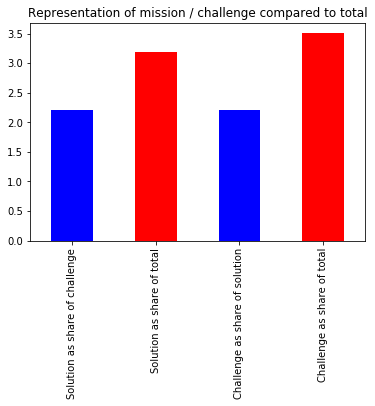

In [292]:
# Are our hypothesis above correct?

comp= pd.Series([100*len(amf_df)/len(cmf_df),100*len(smf_df)/len(projects),
                 100*len(amf_df)/len(cmf_df),100*len(cmf_df)/len(projects)],
               index=['Solution as share of challenge','Solution as share of total',
                     'Challenge as share of solution','Challenge as share of total'])
comp.plot.bar(color=['blue','red','blue','red'],title='Representation of mission / challenge compared to total')


The solution seems underrepresented in the challenge compared to the total of projects

The challenge seems underrepresented in the solution compared to the total of projects

#### Trends

We assume growth in the effective mission field but potentially slower than either of its components (there is some sort of barrier preventing the application of the solution to the challenge).

$\frac{\delta MF_a}{\delta t} < \frac{\delta A}{\delta t}$

$\frac{\delta MF_a}{\delta t} < \frac{\delta C}{\delta t}$

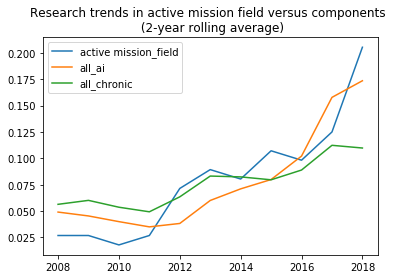

In [293]:
trends = pd.concat([df.year.value_counts(normalize=1) for df in [amf_df,smf_df,cmf_df]],axis=1)

trends.columns =['active mission_field','all_ai','all_chronic']
trends = trends.loc[(trends.index>2006) & (trends.index<2019)]

trends.rolling(window=2).mean().plot(title='Research trends in active mission field versus components \n (2-year rolling average)')

Recent period is relatively more important for AI and the active mission field. This suggests a diffusion of AI into the treatment of chronic diseases.

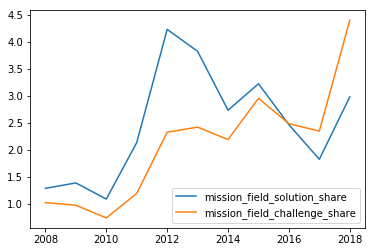

In [294]:
trends_as_share = pd.concat([df.year.value_counts() for df in [amf_df,smf_df,cmf_df]],axis=1)

trends_as_share.columns = ['mission','solution','challenge']

trends_as_share['mission_field_solution_share'],trends_as_share['mission_field_challenge_share'] = [
    trends_as_share['mission']/trends_as_share[x] for x in ['solution','challenge']]

(100*trends_as_share.loc[(trends_as_share.index>2006) & (trends_as_share.index<2019),
                   ['mission_field_solution_share','mission_field_challenge_share']]).rolling(window=2).mean().plot()


This one picks up the mission active field as a share of solution and challenge

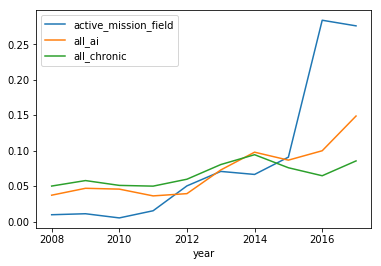

In [295]:
funding_trends = pd.concat([df.groupby('year')['amount'].sum() for df in [amf_df,smf_df,cmf_df]],axis=1)

funding_shares = funding_trends.apply(lambda x: x/x.sum(),axis=0)
funding_shares = funding_shares.loc[(funding_shares.index>2006) & (funding_shares.index<2018)]

funding_shares.columns = ['active_mission_field','all_ai','all_chronic']

funding_shares.rolling(window=2).mean().plot()

! What happened after 2015?

In [296]:
for a in amf_df.loc[amf_df.year>2014].sort_values('amount',ascending=False)['abstract'][:5]:
    print(a[:1000])
    
    print('=====')
    print('=====')
    

The global economy is undergoing a data-driven revolution. Exponential growth in the volume of personal and professional data is raising huge new opportunities and challenges for organisations and individuals. Properly processed and analysed, data can lead to radical innovations, enabling significant value creation. Worldwide revenues for big data analytics are estimated to grow from nearly $122bn in 2015 to more than $187bn in 2019, an increase of more than 50% over the period.

However, whilst the enormous potential for data innovation to increase productivity across all organisations is widely recognised, many organisations will not benefit due to an acute skills shortage. PwC's 2015 Annual CEO Survey found that 80% of UK CEOs see data analytics as a key strand of their strategy and a source of competitive advantage, 73% believe that availability of key skills is a major threat. Subsequently, various Government funded reports have supported this conclusion, recognising that the digi

Several of the projects that we identify are quite broad and only set out to do chronic diseases among many other things. We need a better filter

#### Funding

The funder for the mission fied might be different from the funder for the constituent parts. I would expect the mission funder to be related (closer) to the challenge.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


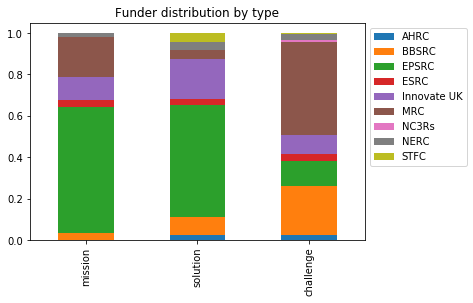

In [297]:
funders = pd.concat([df['funder'].value_counts(normalize=1) for df in [amf_df,smf_df,cmf_df]],axis=1)

funders.columns = ['mission','solution','challenge']

fig,ax = plt.subplots()

funders.T.plot.bar(stacked=True,ax=ax,title='Funder distribution by type')
ax.legend(bbox_to_anchor=(1,1))

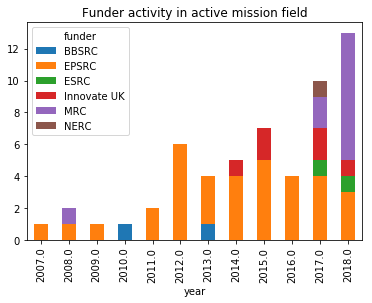

In [298]:
pd.crosstab(amf_df['year'],amf_df['funder']).plot.bar(stacked=True,title='Funder activity in active mission field')

#### Discipline mix

The effective mission field will contain a higher level of discipline diversity than the constituent parts (although here we need to remember that the constituent parts might also be related to other missions we are not capturing).

In [299]:
from scipy.stats import entropy

discs = ['biological_sciences', 'physics', 'engineering_technology',
       'medical_sciences', 'social_sciences', 'mathematics_computing',
       'environmental_sciences', 'arts_humanities']



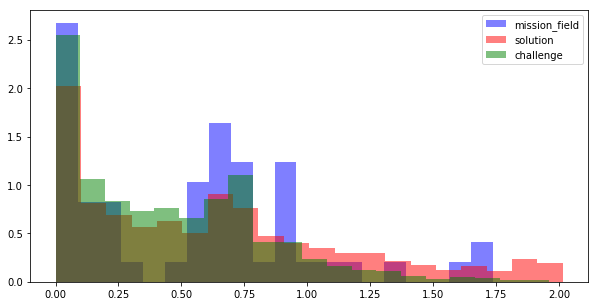

In [300]:
amf_ent,sol_ent,chal_ent = [df[discs].apply(entropy,axis=1) for df in [amf_df,smf_df,cmf_df]]

fig,ax = plt.subplots(figsize=(10,5))

ax.hist(amf_ent,bins=20,color='blue',alpha=0.5,density=True)
ax.hist(sol_ent,bins=20,color='red',alpha=0.5,density=True)
ax.hist(chal_ent,bins=20,color='green',alpha=0.5,density=True)
ax.legend(['mission_field','solution','challenge'])

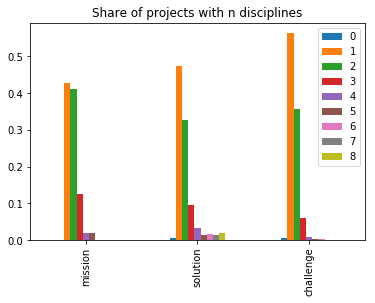

In [301]:
disc_distr = pd.concat([df[discs].applymap(lambda x: x>0.1).sum(axis=1).value_counts(normalize=True) 
                                  for df in [amf_df,smf_df,cmf_df]],axis=1).fillna(0)


disc_distr.columns = ['mission','solution','challenge']

disc_distr.T.plot.bar(title='Share of projects with n disciplines')

It does seem that the mission field tends to combine projects with multiple disciplines

### Impacts

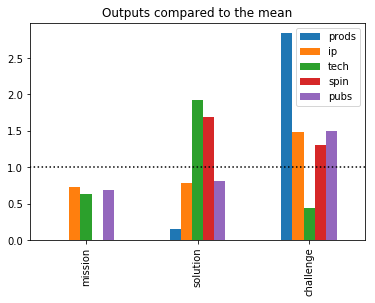

In [302]:
imps = ['prods', 'ip', 'tech', 'spin', 'pubs']


imps_share = pd.concat([df[imps].mean() for df in [amf_df,smf_df,cmf_df]],axis=1)
imps_share.columns = ['mission','solution','challenge']

fig,ax = plt.subplots()

(imps_share.T/imps_share.T.mean()).plot.bar(ax=ax,title='Outputs compared to the mean')

ax.hlines(y=1,xmin=-1,xmax=3,linestyles=':')

Mission projects tend to generate less technological outputs although this could be because they are on average younger

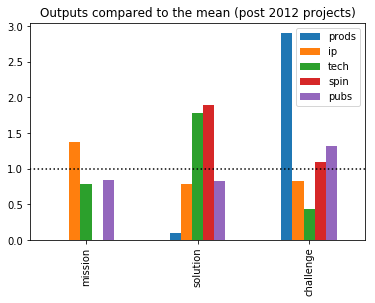

In [303]:
imps_share_y = pd.concat([df.loc[df.year>2012,imps].mean() for df in [amf_df,smf_df,cmf_df]],axis=1)
imps_share_y.columns = ['mission','solution','challenge']

fig,ax = plt.subplots()

(imps_share_y.T/imps_share_y.T.mean()).plot.bar(ax=ax,title='Outputs compared to the mean (post 2012 projects)')

ax.hlines(y=1,xmin=-1,xmax=3,linestyles=':')

Somewhat interestingly, when we constrain the analysis to post-2012 projects, the mission field tends to generate more IP. I doubt the differences are significant though

**One concern with all the above is that some of the projects we pick up are very generic. I also worry that we might be missing some relevant projects without the keywords**

Maybe we could use doc2vec to find docs which are highly similar to some high chronic disease scoring projects?

Let's see.

## Doc2Vec project expansion

We train a doc2vec model that looks for projects which are semantically closed to those we identify as highly relevant for the challenge

In [307]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [317]:
tagged_documents = [TaggedDocument(doc,[num]) for num,doc in enumerate(corpus_tokenised.tokenised)]

In [318]:
d2v = Doc2Vec(tagged_documents)

In [340]:
#Ok, now I want to find the most similar documents a list of projects with 
#more than 1 occurrence of chronic related words and more than one occurrence of chronic occurring words
projects['has_ai_n'],projects['has_chronic_n'] = [querier(corpus_tokenised.tokenised,keys,
                                                     intersect=False) for keys in [ai_expanded,chronic_expanded]]


In [457]:
high_indices = list(projects.reset_index(drop=True).loc[(projects.has_ai_n>1) & (projects.has_chronic_n>1)].index)

high_indices

[16341, 24993, 29266, 35236, 47396, 68873]

In [468]:
#This extracts those projects that are semantically closer to the initial list. 

close_docs = []

for ind in high_indices:
    sims = d2v.docvecs.most_similar([d2v.infer_vector(tagged_documents[ind].words)],topn=20)
    
    #Here we remove those projects that were already identified as high indices
    close_docs.append([s[0] for s in sims if (s[0] not in high_indices) & (s[1]>0.6)])


/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [469]:
sims = set(flatten_list(close_docs))

for t in projects.iloc[list(sims)]['title']:
    print(t)

Skin Reflectance and Face Shape Estimation Using Photometric Stereo
PrivInfer - Programming Languages for Differential Privacy: Conditioning and Inference
Wearable neuroimaging technologies for the neonatal intensive care unit: mapping sensorimotor disruption in infants at risk of cerebral palsy.
Projective Limit Techniques and Representation Theorems in Bayesian Nonparametrics
Investigating newborn brain function and behaviour associated with prematurity and brain injury
An investigation into the use of shrinkage methods to alleviate over-fitting of prognostic models for independent and clustered data with few events
Multidimensional and Multiparametric Quantitative Cardiac MRI from Continuous Free-Breathing Acquisition
Intelligent search assistance
EnAKTing the Unbounded Data Web: Challenges in Web Science
Argudas - argumentation-based data sharing across gene expression databases
SAMS - Software Architecture for Mental health Self management
An EPSRC National Research Facility to fa

Some of them look quite relevant. Others, not so much. 

### Next steps (Friday)

* Produce a better query system: a better seed list would help.
* Package the descriptive stat generator into a function or class. This should be generic enough to accept dfs from other sources (eg H2020 and OpenAIRE).
* Reimplement and test the above. Check how many of the new projects were already captured by the two broader categories
* Organisation visualisation

### Other combinations
* Integrate with TRL analysis
* Integrate with SDG analysis
* Check social media discussion around papers


### Ageing and inclusion/inequality (crude keyword search-based)

In [243]:
age_expanded = synonym_chaser(seed_list=['ageing','aging'],model=w2v,similarity=0.8)
inclusion_expanded = synonym_chaser(seed_list=['inclusion','inclusiveness','inclusive','inequality'],model=w2v,similarity=0.8)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [244]:
projects['has_age'],projects['has_inclusion'] = [querier(corpus_tokenised.tokenised,keys) for keys in [age_expanded,inclusion_expanded]]

In [245]:
pd.crosstab(projects['has_age']>0,projects['has_inclusion']>0)

has_inclusion,False,True
has_age,,
False,68628,1727
True,1964,37


In [20]:
projects.loc[(projects['has_age']>0) & (projects['has_inclusion']>0)].head()

,index,title,year,abstract,status,grant_category,funder,amount,biological_sciences,physics,...,arts_humanities,prods,ip,tech,spin,pubs,has_ai,has_chronic,has_age,has_inclusion
2370,098AFC90-05C9-4F53-A584-F780EA2BD004,MECHANISM OF INFLAMMATION IN ENVIRONMENTAL ENT...,2018.0,Malnutrition is the greatest barrier to health...,Active,Fellowship,MRC,815863.0,0.000027,1.192120e-08,...,0.000001,0.0,0.0,0.0,0.0,0.0,0,1,1,1
2656,0AA6BCA6-50DD-4767-87B2-AFE0D7399233,Enabling Ongoingness: Content Creation &amp; C...,2017.0,The 'oldest old' are the fastest growing age g...,Active,Research Grant,EPSRC,885437.0,0.000029,1.483308e-09,...,0.415132,0.0,0.0,0.0,0.0,0.0,0,0,1,1
10048,27E22B78-1328-4874-B4A1-A2BBD48F00D7,Causes of heterogeneity in ageing - the Whiteh...,2010.0,When the Whitehall II study started in 1985 it...,Closed,Research Grant,MRC,2099998.0,0.000966,4.291643e-08,...,0.000847,0.0,0.0,0.0,0.0,944.0,0,1,3,1
10142,2835D915-D062-4B01-89BC-140637C6A54D,How do neighbourhood deprivation and neighbour...,2017.0,How do neighbourhood deprivation and neighbour...,Active,Studentship,ESRC,0.0,0.001661,4.205033e-06,...,0.001017,0.0,0.0,0.0,0.0,0.0,0,0,1,1
10178,28649AB9-D8A5-4017-905A-7A4147D98915,Family Demography and Health in Low- and Middl...,2013.0,Intergenerational relations involve the exchan...,Closed,Research Grant,ESRC,17070.0,0.000142,1.276702e-07,...,0.002074,0.0,0.0,0.0,0.0,14.0,0,0,1,1


In [25]:
1100*2/3

733.3333333333334